## Particle within radius or overlap calculations

In [1]:
#user-defined
# import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist


#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns

#misc
import time
np.set_printoptions(suppress=True)

In [2]:
dir_save = '../../data/Sprints/AN/'
dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/Run03/Set05/wind05Run03_InterpolatedX.hdf'
# Total/Run03X.hdf'

df = pd.read_hdf(dir)

### Calculate Expected encounters

In [3]:
# df=pd.concat([df1,df2,df3]).reset_index(drop=True)

In [4]:
# df = pd.DataFrame()
# df = pd.read_hdf(dir)
dt= df.master_time[1]-df.master_time[0]

In [5]:
sync_time = df.master_time-df.master_time[0]
df.insert(1,'sync_time',sync_time)

In [6]:
# storing the odor location in a numpy array to avoid reading pandas
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 
source = np.array([[0,0]])
distance_from_source = np.array([cdist(odor_position,source)]).flatten()

# Is Encountered odor particle within the Calculated particle radius?

The loop below computes locations of the eastwest and northsouth particles and compares with a radius (distance) to interpret if the encountered particle were close to calculated particle. The execution for the loop is 23.56 seconds for 59770 rows of data

For stationery wind sensor: The loop below takes in ith eastwest and subtracts the ith U and V elements to get the i-1 state, as the eastwest is summation of all the wind positions. 

[3 + 2 + 1] = [6]

hence ith _state = 6

_state = _state-3

_state = _state-2

In [86]:
# m = []
# a = np.array([[9,0],[6,0],[5,0],[4,0],[3,0],[2,0],[1,0]])
# b = np.array([[7,0]])
# dis = cdist(b,a).flatten()
# print('distance', dis)
# print(np.where(dis == np.amin(dis)))
# n = len(a)
# x = [a[i][0] for i in range(n)]
# y = [a[i][1] for i in range(n)]
# # x,y = zip(*a)
# start = time.time()
# print(pathlength(x, y))
# time.time()-start


# a = np.array([[1,0],[0,1]])
# n = len(a)
# x = [a[i][0] for i in range(n)]
# y = [a[i][1] for i in range(n)]
# # x,y = zip(*a)
# start = time.time()
# print(pathlength(x, y))
# time.time()-start

In [76]:
eastwest = [np.sum(df.U[j:])*dt for j in range(0,len(df))]
northsouth = [np.sum(df.V[j:])*dt for j in range(0,len(df))]

In [91]:
nearest_from_streakline = []
distance_along_streakline = []
def compute_distance(streakline, odor_position):
    print(streakline)
    distance = cdist(odor_position,streakline).flatten()   # cdist compares distance for all the points in both arrays
    pos = np.where(distance == np.amin(distance))
    nearest_from_streakline.append( np.min(distance))
    length=(np.sqrt(np.sum(np.diff(np.array(streakline[int(pos[0]):]), axis=0)**2, axis=1)))
    distance_along_streakline.append(np.sum(length))
    return (pos, np.min(distance),np.sum(length))

In [99]:
a = np.array([[1,1],[2,2],[3,3],[4,4],[5,5]])
b = np.array([[1,1]])
print(compute_distance(a,b))

[[1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]]
((array([0]),), 0.0, 5.656854249492381)


In [90]:
for i in range(len(eastwest)-1, len(eastwest)-5, -1):
    odor_pos = [odor_position[i]]  
    eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
    northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
    wind_pos = np.vstack([eastwest[-6000:],northsouth[-6000:]]).T   
    compute_distance(wind_pos,odor_pos)

In [59]:
#for the section when only the length of the elements is equal to the window value
for i in range((len(eastwest))-1, -1, -1):
    
    odor_pos = [odor_position[i]]  
    if(i == 0):
        radius = np.zeros(1)
        wind_pos = np.array([[0,0]])
    else:
        eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
        northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
        wind_pos = np.vstack([eastwest,northsouth]).T   
        
    compute_distance(wind_pos,odor_pos)


In [37]:
## flip containers because above iteration is done in reverse order
df['mock'] = np.zeros(len(df))
distance_along_streakline = np.array(np.flip(distance_along_streakline)) 
# odor_presence = odor_presence[::-1]
# max_radius = max_radius[::-1]

## storing in the dataframe 
# df['odor_expected'] = odor_presence
df['distance_along_streakline'] =  distance_along_streakline
df['nearest_particle'] = nearest_from_streakline
df['distance_from_source'] = distance_from_source


In [38]:
query = 'odor>=2'
df_occurence = df.query(query)

x = np.linspace(0,25,25)
y = np.linspace(0,25,25)
H1, x, y = np.histogram2d(df_occurence.distance_along_streakline, df_occurence.nearest_particle, bins=(x, y), 
                          weights = df_occurence.odor)
H1 = H1.T 
H2, x, y = np.histogram2d(df.distance_along_streakline, df.nearest_particle, bins=(x, y), 
                          weights = df.odor)
H2 = H2.T 

In [ ]:
#filtering
Total = H2
N_Encounter = H1
for i in range (len(Total)):
    for j in range(len(Total[i])):
        if Total[i][j]<500:
            Total[i][j] =0
            N_Encounter[i][j]=0

Encounters = np.array(N_Encounter)/np.array(Total)
Encounters[Encounters == np.inf] = 0

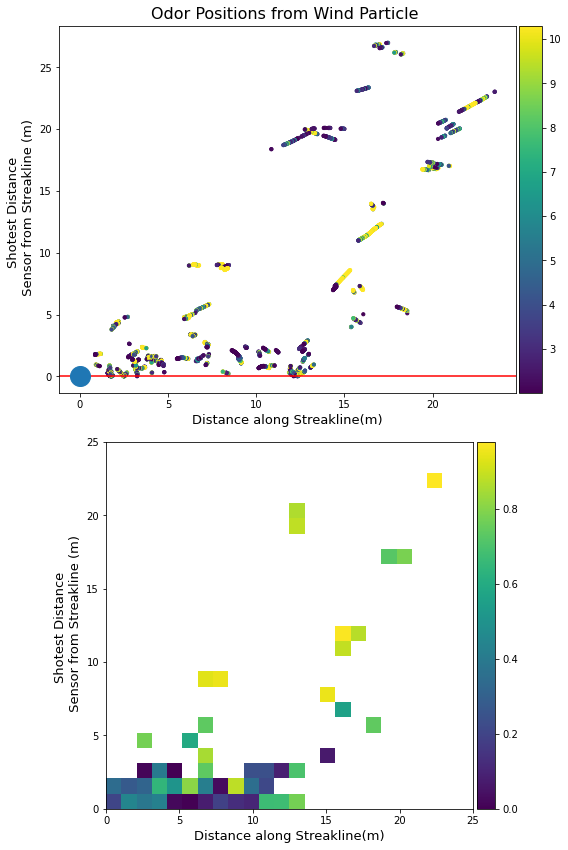

In [43]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(8,12) , gridspec_kw={'height_ratios': [4,4]})

#plot wind vs odor from source and each other
f.suptitle('Odor Positions from Wind Particle', fontsize = 16)
# ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
var = ax1.scatter(df_occurence.distance_along_streakline, df_occurence.nearest_particle, cmap = 'viridis', 
                  c = df_occurence.odor,  s = 10)
ax1.set_xlabel('Distance along Streakline(m)' , fontsize = 13)
ax1.set_ylabel('Shotest Distance \n Sensor from Streakline (m)' , fontsize = 13)


divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'vertical')

# x = np.linspace(0,25,11)
# y = np.linspace(0,10,25)
ax2.set_xlabel('Distance along Streakline(m)', fontsize = 13)
ax2.set_ylabel('Shotest Distance \n Sensor from Streakline (m)', fontsize = 13)
var2 = ax2.imshow(Encounters, interpolation='nearest', origin='lower',cmap = 'viridis', extent=[x[0], x[-1], y[0], y[-1]])
start, end = ax2.get_xlim()

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var2, cax=cax, orientation = 'vertical')

f.tight_layout()

# f.savefig(dir_save+'Run03Set05_NewStreak_Filtered.jpeg')

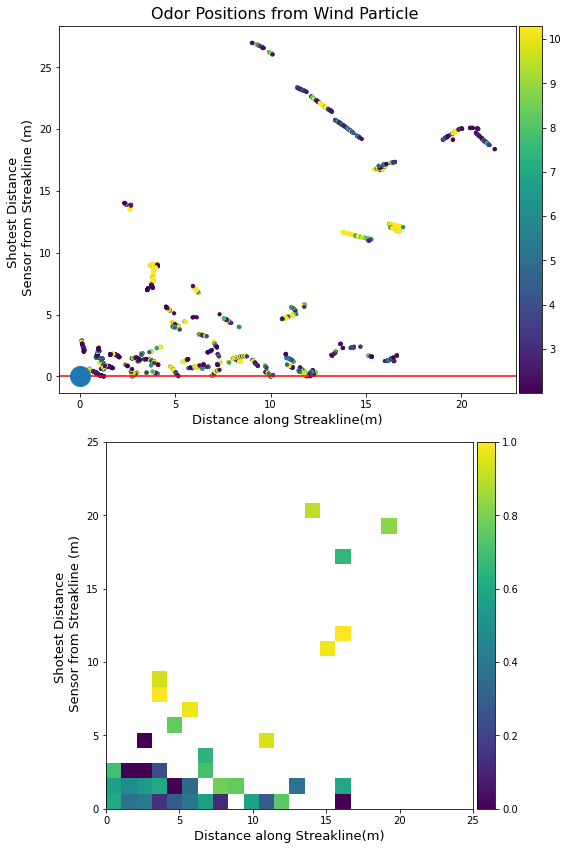

In [40]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(8,12) , gridspec_kw={'height_ratios': [4,4]})

#plot wind vs odor from source and each other
f.suptitle('Odor Positions from Wind Particle', fontsize = 16)
# ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
var = ax1.scatter(df_occurence.distance_along_streakline, df_occurence.nearest_particle, cmap = 'viridis', 
                  c = df_occurence.odor,  s = 10)
ax1.set_xlabel('Distance along Streakline(m)' , fontsize = 13)
ax1.set_ylabel('Shotest Distance \n Sensor from Streakline (m)' , fontsize = 13)


divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'vertical')

# x = np.linspace(0,25,11)
# y = np.linspace(0,10,25)
ax2.set_xlabel('Distance along Streakline(m)', fontsize = 13)
ax2.set_ylabel('Shotest Distance \n Sensor from Streakline (m)', fontsize = 13)
var2 = ax2.imshow(Encounters, interpolation='nearest', origin='lower',cmap = 'viridis', extent=[x[0], x[-1], y[0], y[-1]])
start, end = ax2.get_xlim()

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var2, cax=cax, orientation = 'vertical')

f.tight_layout()

# f.savefig(dir_save+'Run03Set05_NewStreak_Filtered.jpeg')